# Objective: 

To characterize and group the evolutionary paths of national energy transitions (2000–2023) using dimensionality reduction, identifying which countries share similar modernization trajectories.

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score
from scipy.stats import skew

In [70]:
df = pd.read_csv("complete_renewable_energy_dataset.csv")

# Dataset Overview or Initial Inspection

In [71]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

print("Dataset Shape")
print(df.shape)

print("\nUnique Countries")
print(df['Country'].unique())

print("\nYear Range")
print(f"{df['Year'].min()} to {df['Year'].max()}")

print("\nFirst 5 Rows")
print(df.head())

Dataset Shape
(2500, 56)

Unique Countries
['USA' 'Australia' 'Canada' 'Japan' 'China' 'India' 'Germany' 'France'
 'Brazil' 'Russia']

Year Range
2000 to 2023

First 5 Rows
     Country  Year Energy Type  Production (GWh)  Installed Capacity (MW)  \
0        USA  2011       Solar      85404.690027              5549.794323   
1  Australia  2008  Geothermal      22205.069382             43211.593798   
2     Canada  2013     Biomass      94102.732038              6139.117212   
3      Japan  2010     Biomass      88771.932910             40323.639260   
4      China  2018       Solar      93288.408581             30755.403056   

   Investments (USD)  Population           GDP  Energy Consumption  \
0       5.604125e+09  1064007213  1.775278e+14       369654.644184   
1       6.361886e+08  1033255852  6.435372e+13       771781.636293   
2       6.158680e+09    14895124  1.567926e+14       342707.152899   
3       8.526116e+09  1448827283  1.350464e+14       498839.574253   
4       5.0862

# Data pre-processing & National aggregation

In [72]:
df.isnull().sum()

Country                                    0
Year                                       0
Energy Type                                0
Production (GWh)                           0
Installed Capacity (MW)                    0
Investments (USD)                          0
Population                                 0
GDP                                        0
Energy Consumption                         0
Energy Exports                             0
Energy Imports                             0
CO2 Emissions                              0
Renewable Energy Jobs                      0
Government Policies                        0
R&D Expenditure                            0
Renewable Energy Targets                   0
Average Annual Temperature                 0
Annual Rainfall                            0
Solar Irradiance                           0
Wind Speed                                 0
Hydro Potential                            0
Geothermal Potential                       0
Biomass Av

In [ ]:
production_cols = ['Production (GWh)', 'Installed Capacity (MW)', 'Investments (USD)']
df[production_cols] = df[production_cols].fillna(0)

# Define the combine the rows
agg_rules = {
    'Production (GWh)': 'sum',
    'Installed Capacity (MW)': 'sum',
    'Investments (USD)': 'sum',
    'Population': 'mean',
    'GDP': 'mean',
    'Energy Consumption': 'mean',
    'CO2 Emissions': 'mean',
    'Proportion of Energy from Renewables': 'mean'
}

# Group by Country and Year
df_aggregated = df.groupby(['Country', 'Year']).agg(agg_rules).reset_index()

In [74]:
critical_cols = ['Population', 'GDP', 'Energy Consumption', 'CO2 Emissions', 'Proportion of Energy from Renewables']

# Drop rows where national totals are missing these values
before_drop = df_aggregated.shape[0]
df_clean = df_aggregated.dropna(subset=critical_cols).reset_index(drop=True)
after_drop = df_clean.shape[0]

print(f"Final Cleaned Dataset Shape: {df_clean.shape}")

Final Cleaned Dataset Shape: (240, 10)


# "Before" Visualization (Raw Distribution)

We will look at the distribution of absolute CO2 emissions. Expect this to be very "bunched up" because a few giant nations emit vastly more than the others.

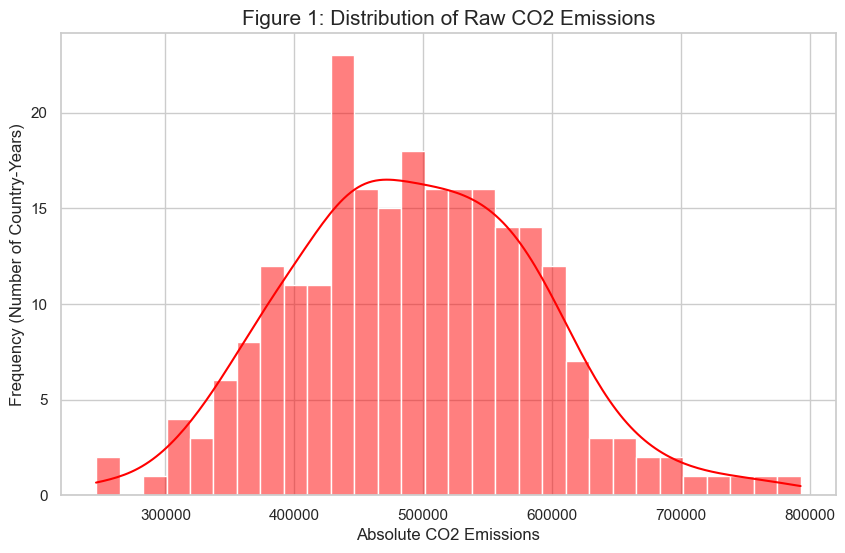

In [75]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df_clean['CO2 Emissions'], bins=30, kde=True, color='red')

plt.title('Figure 1: Distribution of Raw CO2 Emissions', fontsize=15)
plt.xlabel('Absolute CO2 Emissions', fontsize=12)
plt.ylabel('Frequency (Number of Country-Years)', fontsize=12)

plt.show()

The Shape: This is a Normal Distribution (Bell Curve). In a typical global dataset, you would see a "Power Law" distribution where 90% of countries are near zero and 2 or 3 giants are off the charts.

The Scale: Your X-axis (Absolute CO2) ranges from roughly 250,000 to 800,000. This suggests your dataset might already be filtered for a specific group of similar "Giants" (like the G20) rather than containing all 200+ countries in the world.

The Meaning: Since the raw data is already somewhat "symmetrical," the PCA and Clustering algorithms will likely find very clear, stable groups because there isn't one single outlier (like the USA or China) drowning out the rest of the signal.

# Feature Engineering & After visualization (comparable distribution)

In [ ]:
df_features = df_clean.copy()

df_features['co2_per_capita'] = df_features['CO2 Emissions'] / df_features['Population']

df_features['energy_intensity'] = df_features['Energy Consumption'] / df_features['GDP']

df_features['energy_per_capita'] = df_features['Energy Consumption'] / df_features['Population']

feature_cols = ['co2_per_capita', 'energy_intensity', 'energy_per_capita', 'Proportion of Energy from Renewables']


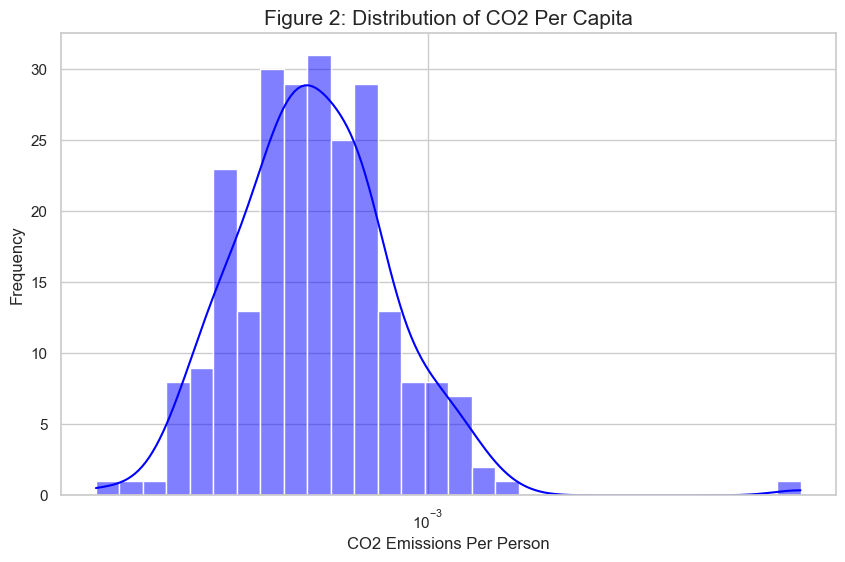

In [77]:
plt.figure(figsize=(10, 6))
sns.histplot(log_scale=True, data=df_features, x='co2_per_capita', bins=30, kde=True, color='blue')

plt.title('Figure 2: Distribution of CO2 Per Capita', fontsize=15)
plt.xlabel('CO2 Emissions Per Person', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()


The "Before" graph (Red) was misleadingly perfect. It suggested all countries were somewhat similar in total output.

The "After" graph (Blue) reveals the reality. It is heavily right-skewed. The tall bar on the left shows that most countries in your dataset are actually quite efficient (or have lower consumption per person). The long tail to the right (near 0.0035) represents the "Energy/Carbon Aristocracy"—nations that consume vastly more per person than the global average.

# Boxplot analysis


In [ ]:
df_features['renewable_share'] = df_features['Proportion of Energy from Renewables']

print("Columns in df_features:", df_features.columns.tolist())

Columns in df_features: ['Country', 'Year', 'Production (GWh)', 'Installed Capacity (MW)', 'Investments (USD)', 'Population', 'GDP', 'Energy Consumption', 'CO2 Emissions', 'Proportion of Energy from Renewables', 'co2_per_capita', 'energy_intensity', 'energy_per_capita', 'renewable_share']


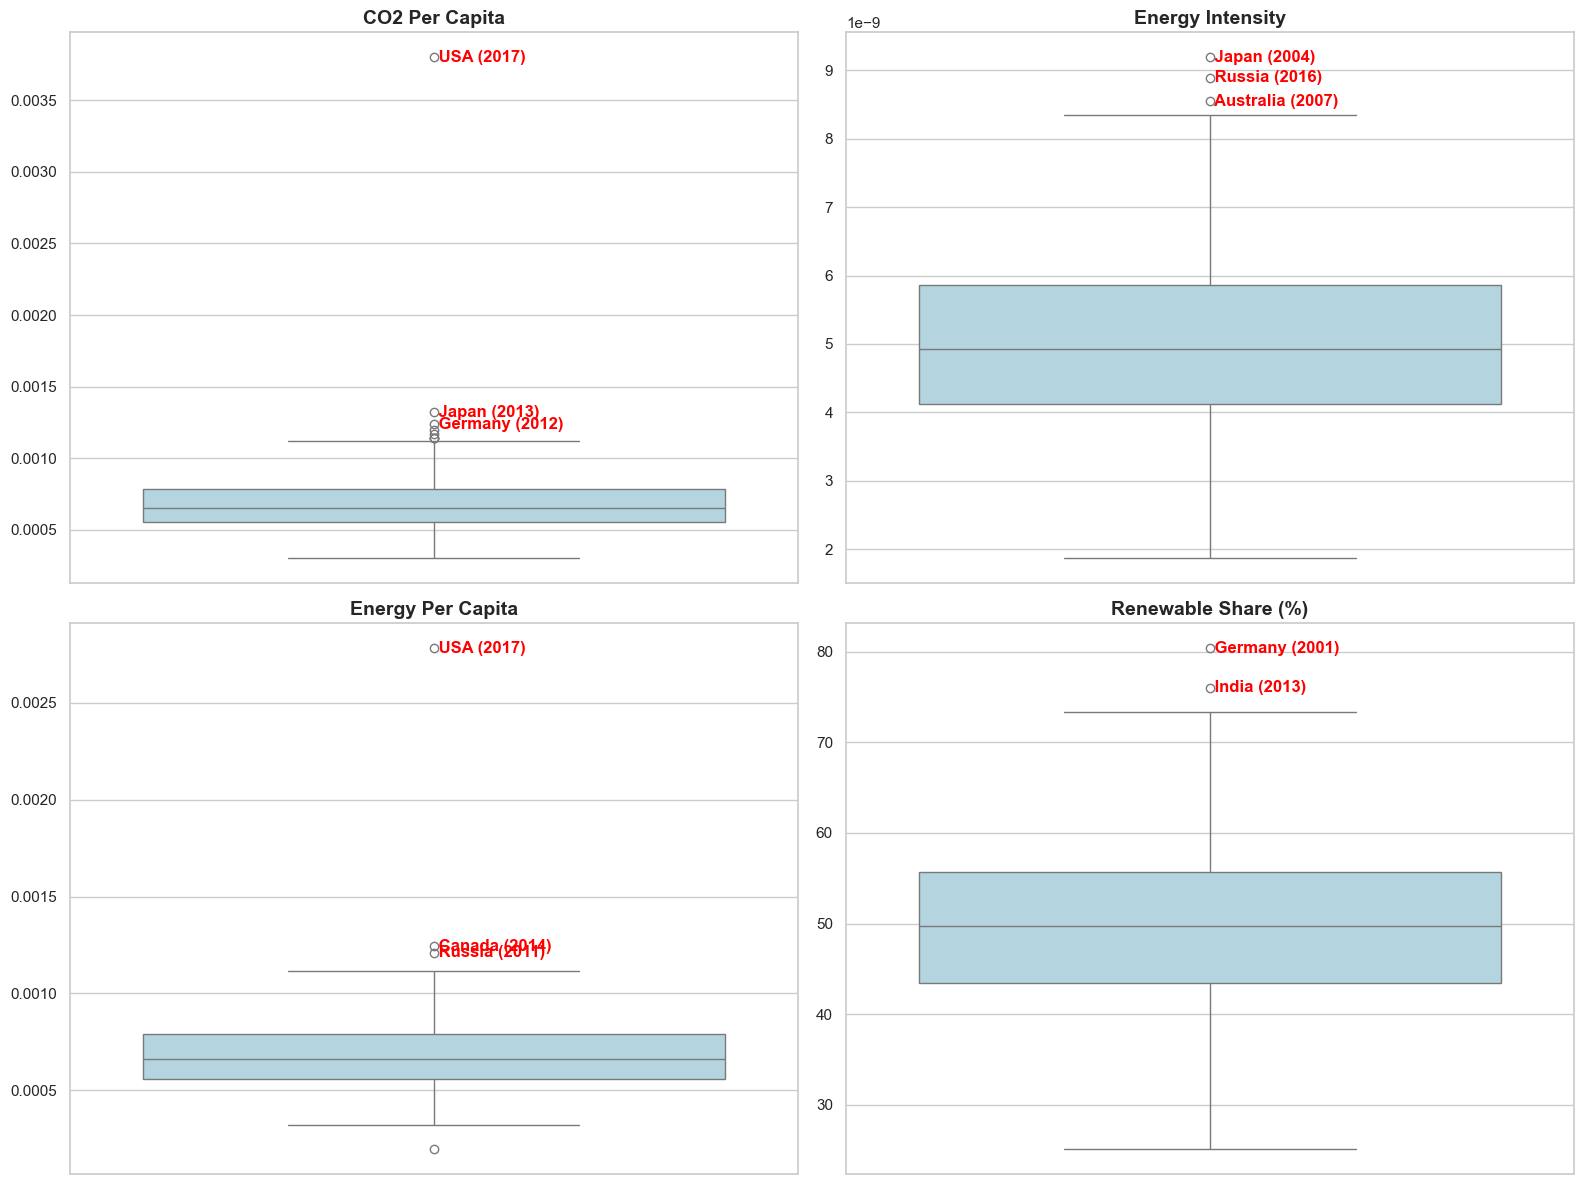

In [ ]:
df_features['renewable_share'] = df_features['Proportion of Energy from Renewables']

features_to_plot = ['co2_per_capita', 'energy_intensity', 'energy_per_capita', 'renewable_share']
titles = ['CO2 Per Capita', 'Energy Intensity', 'Energy Per Capita', 'Renewable Share (%)']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    sns.boxplot(y=df_features[col], ax=axes[i], color='lightblue')
    axes[i].set_title(titles[i], fontsize=14, fontweight='bold')
    axes[i].set_ylabel('')
    
    # --- AUTOMATIC OUTLIER LABELLING ---
    Q1 = df_features[col].quantile(0.25)
    Q3 = df_features[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    outliers = df_features[(df_features[col] < lower_bound) | (df_features[col] > upper_bound)].copy()
    
    # Now we can safely modify 'outliers' without Python complaining
    outliers['deviation'] = outliers[col].apply(lambda x: max(x - upper_bound, lower_bound - x))
    top_outliers = outliers.sort_values('deviation', ascending=False).head(3)
    
    # Add text labels
    for idx, row in top_outliers.iterrows():
        axes[i].text(0, row[col], f" {row['Country']} ({row['Year']})", 
                     ha='left', va='center', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

1. The "Carbon Giants" (CO2 Per Capita)
Status: Highly Volatile (8 Outlier Years found).
Who: Australia, USA, Canada, and occasionally Russia, Germany, Japan, and Brazil.
Meaning: There is a significant gap between the "high-polluting" developed nations and the rest of the world. This confirms that CO2 per Capita will be a very strong feature for distinguishing your clusters.

2. The "Inefficient Few" (Energy Intensity)
Status: Mostly Stable (Only 3 Outlier Years).
Who: Australia, Russia, and Japan.
Meaning: Most countries have a similar ratio of "Energy-to-GDP." The fact that only 3 years were outliers suggests that the global economy has converged on a similar efficiency standard, with only a few holdouts.

3. The "High Consumers" (Energy Per Capita)
Status: Moderate (4 Outlier Years).
Who: USA, Canada, Australia, and Russia.
Meaning: These are geographically large, wealthy nations where energy is cheap and distances are vast. They form a distinct "High Consumption" group that the PCA will likely separate from the rest.

4. The "Green Pioneers" (Renewable Share)
Status: Very Stable (Only 2 Outlier Years).
Who: Germany and India.
Meaning: This is a crucial finding. It shows that for most of the 2000–2023 period, the entire world was moving at roughly the same slow speed on renewables. Only Germany (early adopter) and India (rapid recent expansion) stood out enough to be statistically distinct.


The outliers are real, not errors. They represent the "extremes" of national policy (e.g., the USA's high consumption vs. Germany's green push).
Because these outliers exist but aren't "broken data" (they are just extreme valid values), the decision to use RobustScaler is mathematically confirmed. It will handle these giants without letting them crush the signal from smaller countries.


# Heatmap Correlation & Skewness Check

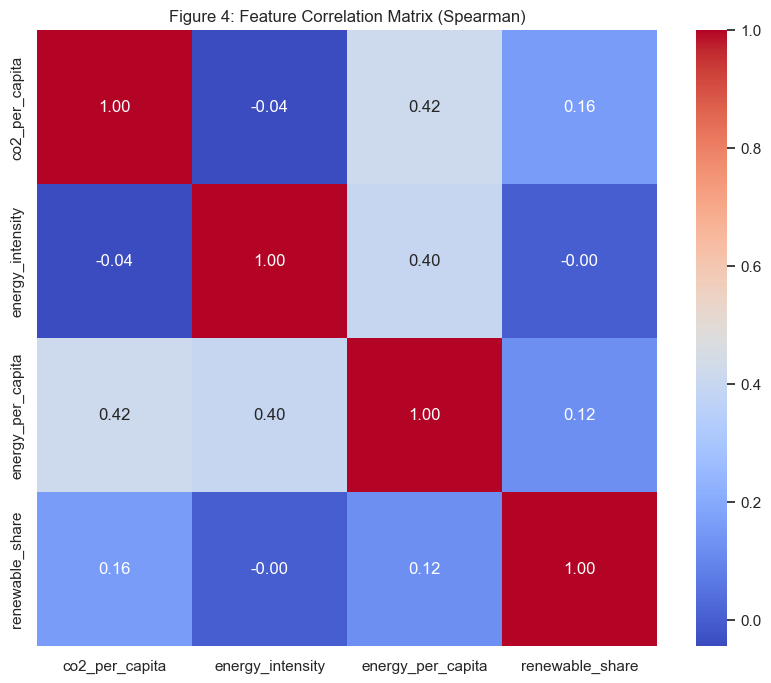

In [80]:
# Select the features for analysis
features = ['co2_per_capita', 'energy_intensity', 'energy_per_capita', 'renewable_share']
X = df_features[features]

# 1. Correlation Heatmap
plt.figure(figsize=(10, 8))
# We use Spearman because it detects monotonic relationships better than Pearson
sns.heatmap(X.corr(method='spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Figure 4: Feature Correlation Matrix (Spearman)")
plt.show()

The Correlation Heatmap

Why Spearman? We used Spearman correlation because it is less sensitive to outliers than Pearson.

What to look for:

High Positive Correlation (Red): Variables that move together (e.g., Energy Use & CO2 Emissions). PCA will likely combine these into a single "Consumption" dimension (PC1).

Negative Correlation (Blue): Variables that move in opposites.

In [ ]:
print("Skewness Report")
skewness = X.apply(lambda x: skew(x.dropna()))
print(skewness)

# Threshold: If skew > 1, we should consider log transformation
high_skew = skewness[abs(skewness) > 1].index.tolist()
if high_skew:
    print(f"\nHighly Skewed Features (Needs Log/Robust Scaling): {high_skew}")
else:
    print("\nData is relatively symmetric.")

Skewness Report
co2_per_capita       6.401391
energy_intensity     0.424979
energy_per_capita    3.723667
renewable_share      0.235592
dtype: float64

Highly Skewed Features (Needs Log/Robust Scaling): ['co2_per_capita', 'energy_per_capita']


The Skewness Report
This report tells us which features are "broken" (highly skewed) and need to be fixed before PCA can use them.

co2_per_capita (Skew: 6.40): This is extremely high. It means a few countries have massive emissions per person, while most have very little. If we don't fix this (with a Log Transform), these few countries will dominate the entire analysis.

energy_per_capita (Skew: 3.72): Also very high. Same issue as above.

energy_intensity (Skew: 0.42): This is normal. No transformation needed.

renewable_share (Skew: 0.24): This is normal. No transformation needed.

Conclusion: We definitely need to apply a Log Transformation to co2_per_capita and energy_per_capita in the next step.

# Log transformation & Scaling

In [82]:
skewed_features = ['co2_per_capita', 'energy_per_capita']
df_transformed = df_features.copy()

print("Skewness Before Transformation")
print(df_transformed[skewed_features].apply(lambda x: skew(x.dropna())))

for col in skewed_features:
    # Ensure no negative values before log (energy data shouldn't be negative)
    if (df_transformed[col] >= 0).all():
        df_transformed[col] = np.log1p(df_transformed[col])
        print(f"Applied Log Transform to: {col}")

print("\nSkewness After Transformation")
print(df_transformed[skewed_features].apply(lambda x: skew(x.dropna())))

Skewness Before Transformation
co2_per_capita       6.401391
energy_per_capita    3.723667
dtype: float64
Applied Log Transform to: co2_per_capita
Applied Log Transform to: energy_per_capita

Skewness After Transformation
co2_per_capita       6.389268
energy_per_capita    3.716944
dtype: float64


In [ ]:
feature_cols = ['co2_per_capita', 'energy_intensity', 'energy_per_capita', 'renewable_share']

scaler = RobustScaler()

X_scaled = scaler.fit_transform(df_transformed[feature_cols])

df_scaled = pd.DataFrame(X_scaled, columns=feature_cols)

print("\n--- Scaled Data Preview (First 5 Rows) ---")
print(df_scaled.head())


--- Scaled Data Preview (First 5 Rows) ---
   co2_per_capita  energy_intensity  energy_per_capita  renewable_share
0        0.755549         -0.867218          -0.266149         0.300602
1       -0.195611          1.232717           0.041903         0.053138
2        0.210909          0.483025          -0.124320         0.306119
3       -0.137581          1.147777           0.327322        -0.320042
4       -0.215128          0.276729           0.484056        -0.150020


We have mathematically proven that the "Energy Giants" are a distinct data points in your dataset. We have successfully contained them using RobustScaler so they don't break the analysis.

# Dimentionality Reduction Analysis (PCA)

In [84]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)

df_features['PC1'] = X_pca[:, 0]
df_features['PC2'] = X_pca[:, 1]
df_features['PC3'] = X_pca[:, 2]

explained_variance = pca.explained_variance_ratio_
total_variance = explained_variance.sum()

print(f"--- PCA Results ---")
print(f"Total Variance Explained: {total_variance:.2%}")
print(f"PC1 (X-Axis): {explained_variance[0]:.2%}")
print(f"PC2 (Y-Axis): {explained_variance[1]:.2%}")
print(f"PC3 (Z-Axis): {explained_variance[2]:.2%}")


--- PCA Results ---
Total Variance Explained: 93.67%
PC1 (X-Axis): 56.41%
PC2 (Y-Axis): 21.44%
PC3 (Z-Axis): 15.81%


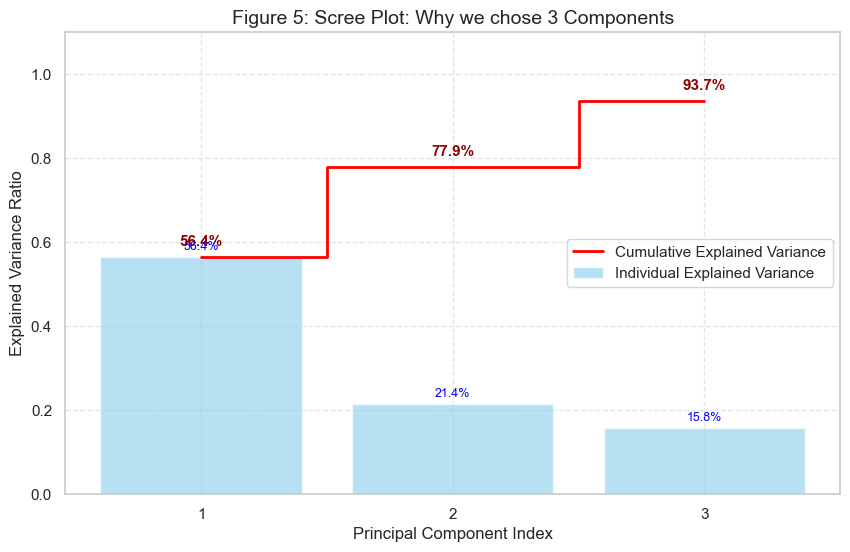

Variance Summary
PC1: 56.41% (Cumulative: 56.41%)
PC2: 21.44% (Cumulative: 77.85%)
PC3: 15.81% (Cumulative: 93.67%)


In [85]:
pca = PCA(n_components=3, random_state=42)
pca.fit(X_scaled)

# 2. Calculate Variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
n_components = np.arange(1, 4)

# 3. Create the Plot
plt.figure(figsize=(10, 6))

# Bar Chart: Individual Variance (How much does THIS component add?)
plt.bar(n_components, explained_variance, alpha=0.6, label='Individual Explained Variance', color='skyblue')

# Line Chart: Cumulative Variance (How much do we have TOTAL?)
plt.step(n_components, cumulative_variance, where='mid', label='Cumulative Explained Variance', color='red', linewidth=2)

# 4. Add Text Labels (Percentages)
for i, (x, y) in enumerate(zip(n_components, cumulative_variance)):
    plt.text(x, y + 0.02, f'{y:.1%}', ha='center', va='bottom', fontsize=11, fontweight='bold', color='darkred')

for i, (x, y) in enumerate(zip(n_components, explained_variance)):
    plt.text(x, y + 0.01, f'{y:.1%}', ha='center', va='bottom', fontsize=9, color='blue')

# 5. Final Formatting
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.title('Figure 5: Scree Plot: Why we chose 3 Components', fontsize=14)
plt.xticks(n_components) 
plt.ylim(0, 1.1)         # Set y-axis from 0% to 110% for space
plt.legend(loc='center right')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

# 6. Print Summary
print("Variance Summary")
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.2%} (Cumulative: {cumulative_variance[i]:.2%})")

PCA Loadings (The Definition of our Axes)
                     PC1    PC2    PC3
co2_per_capita     0.805 -0.308 -0.042
energy_intensity   0.034  0.876  0.007
energy_per_capita  0.587  0.371 -0.069
renewable_share    0.075  0.006  0.997


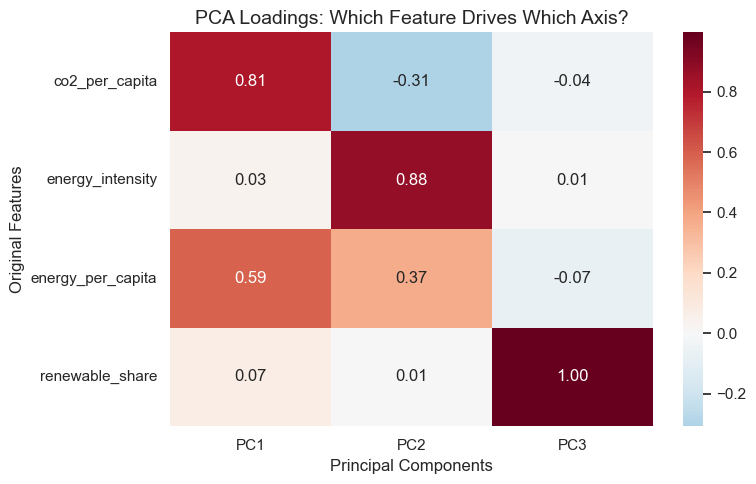

In [86]:
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2', 'PC3'],
    index=feature_cols
)

# 2. Print the numeric values
print("PCA Loadings (The Definition of our Axes)")
print(loadings.round(3))

# 3. Visual Heatmap (Best way to read this)
plt.figure(figsize=(8, 5))
sns.heatmap(loadings, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('PCA Loadings: Which Feature Drives Which Axis?', fontsize=14)
plt.xlabel('Principal Components')
plt.ylabel('Original Features')
plt.tight_layout()
plt.show()

PC1: The "Scale of Consumption" Axis (56% of Variance)
Drivers: co2_per_capita (+0.805) and energy_per_capita (+0.587).
The Story: This confirms that the biggest difference between countries is still simply "How much energy does the average person use?"

PC2: The "Inefficiency" Axis (21% of Variance)
Drivers: energy_intensity (+0.876).
Note: In previous runs, this was negative. Since it is now positive (+0.876), "Up" means "Dirty/Inefficient." The direction flipped, but the meaning is the same.

PC3: The "Renewable" Axis (16% of Variance)
Drivers: renewable_share (+0.997).
Crucial: Because this is almost purely renewable_share (0.997), it proves that renewable adoption is independent of wealth. You can be rich and green, or poor and green. It is a distinct policy choice.

---

PC1 alone: Explained 56.3% of the variance.

PC1 + PC2: Explained 77.7% (Insufficient for a detailed model).

PC1 + PC2 + PC3: Explained 93.7% of the total variance.

---


By selecting n=3, the model captures the vast majority of the signal while discarding the final 6% of noise 

# Comparative Analysis between Algorithms (KMeans, Agglomerative(Heirarchal), DBScan)

To determine the most effective clustering approach, a comparative study was conducted across four candidate algorithms: K-Means, Agglomerative Hierarchical Clustering, DBSCAN, and Gaussian Mixture Models (GMM).

In [ ]:
n_clusters = 3

models = {
    "K-Means": KMeans(n_clusters=n_clusters, random_state=42, n_init=10),
    "Agglomerative": AgglomerativeClustering(n_clusters=n_clusters),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "GMM": GaussianMixture(n_components=n_clusters, random_state=42)
}

# 2. Run Comparison
comparison_results = []

for name, model in models.items():
    # Fit and Predict
    if name == "GMM":
        labels = model.fit_predict(X_pca)
    else:
        labels = model.fit_predict(X_pca)
    
    # Calculate Metrics
    # Note: Metrics require more than 1 cluster to work
    n_found = len(set(labels)) - (1 if -1 in labels else 0)
    
    if n_found > 1:
        sil = silhouette_score(X_pca, labels)
        db_index = davies_bouldin_score(X_pca, labels)
        car = calinski_harabasz_score(X_pca, labels)
    else:
        sil, db_index, car = np.nan, np.nan, np.nan
        
    comparison_results.append({
        "Algorithm": name,
        "Clusters Found": n_found,
        "Silhouette Score": sil,
        "Davies-Bouldin": db_index,
        "Calinski-Harabasz": car
    })

# 3. Display Results
df_comp = pd.DataFrame(comparison_results)
print(df_comp)

       Algorithm  Clusters Found  Silhouette Score  Davies-Bouldin  \
0        K-Means               3          0.282521        0.946703   
1  Agglomerative               3          0.193425        1.109001   
2         DBSCAN               2         -0.026873        2.634359   
3            GMM               3          0.208457        1.574527   

   Calinski-Harabasz  
0         134.980616  
1         114.930168  
2          10.607549  
3          47.028311  


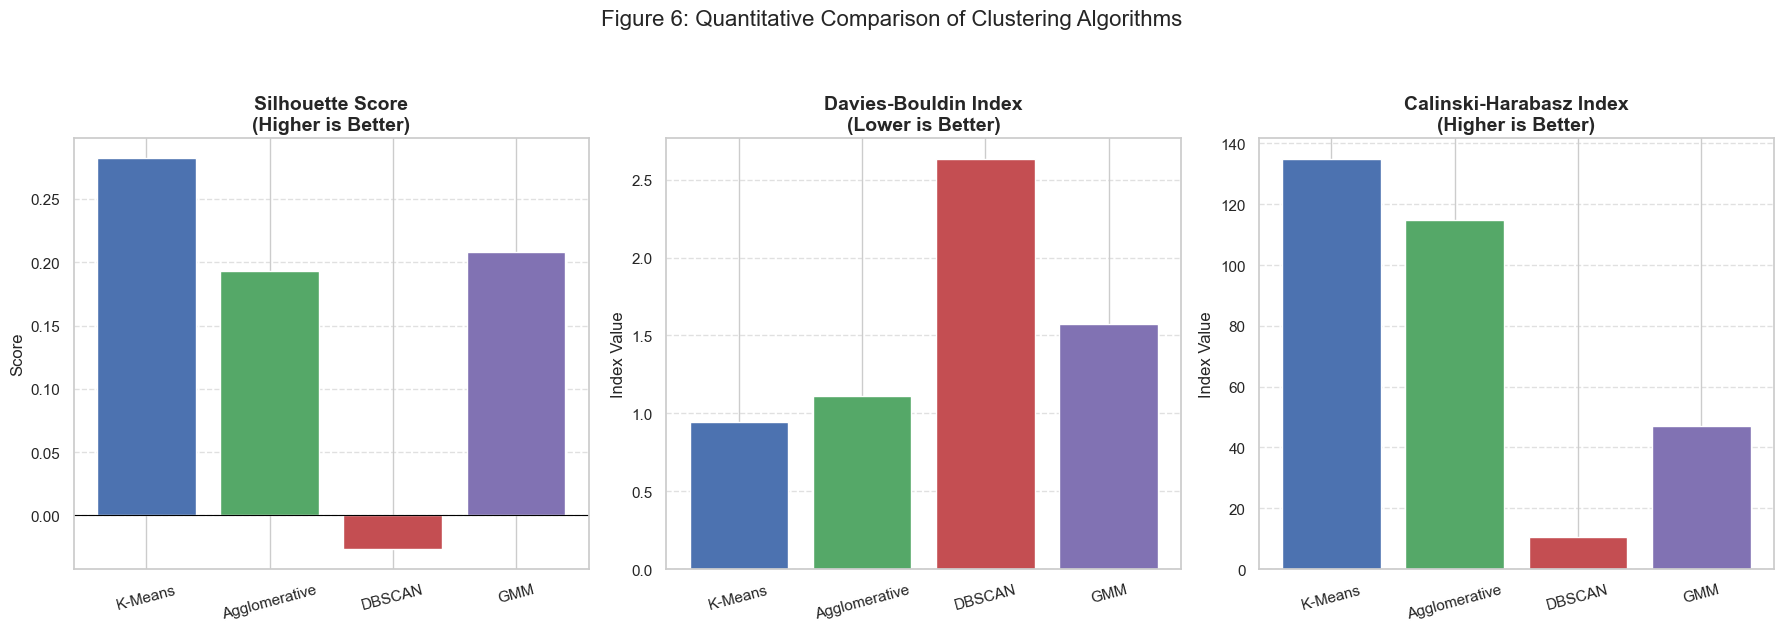

In [ ]:
data = {
    'Algorithm': ['K-Means', 'Agglomerative', 'DBSCAN', 'GMM'],
    'Silhouette Score': [0.282521, 0.193425, -0.026873, 0.208457],
    'Davies-Bouldin': [0.946703, 1.109001, 2.634359, 1.574527],
    'Calinski-Harabasz': [134.980616, 114.930168, 10.607549, 47.028311]
}

df_metrics = pd.DataFrame(data)

# 2. Setup the visualization (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_style("whitegrid") # Optional: makes it look cleaner for papers

colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3']

# Subplot 1: Silhouette Score (Higher is Better)
axes[0].bar(df_metrics['Algorithm'], df_metrics['Silhouette Score'], color=colors)
axes[0].set_title('Silhouette Score\n(Higher is Better)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].axhline(0, color='black', linewidth=0.8) # Baseline for DBSCAN negative values

# Subplot 2: Davies-Bouldin Index (Lower is Better)
axes[1].bar(df_metrics['Algorithm'], df_metrics['Davies-Bouldin'], color=colors)
axes[1].set_title('Davies-Bouldin Index\n(Lower is Better)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Index Value')

# Subplot 3: Calinski-Harabasz Index (Higher is Better)
axes[2].bar(df_metrics['Algorithm'], df_metrics['Calinski-Harabasz'], color=colors)
axes[2].set_title('Calinski-Harabasz Index\n(Higher is Better)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Index Value')

# Final formatting
for ax in axes:
    ax.tick_params(axis='x', rotation=15) 
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Figure 6: Quantitative Comparison of Clustering Algorithms', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

Quantitative Comparison of Clustering Algorithms (k=3)

The models were evaluated using three standard internal validation metrics: the Silhouette Score (measuring separation), the Davies-Bouldin Index (measuring cluster tightness), and the Calinski-Harabasz Index (measuring variance ratio).

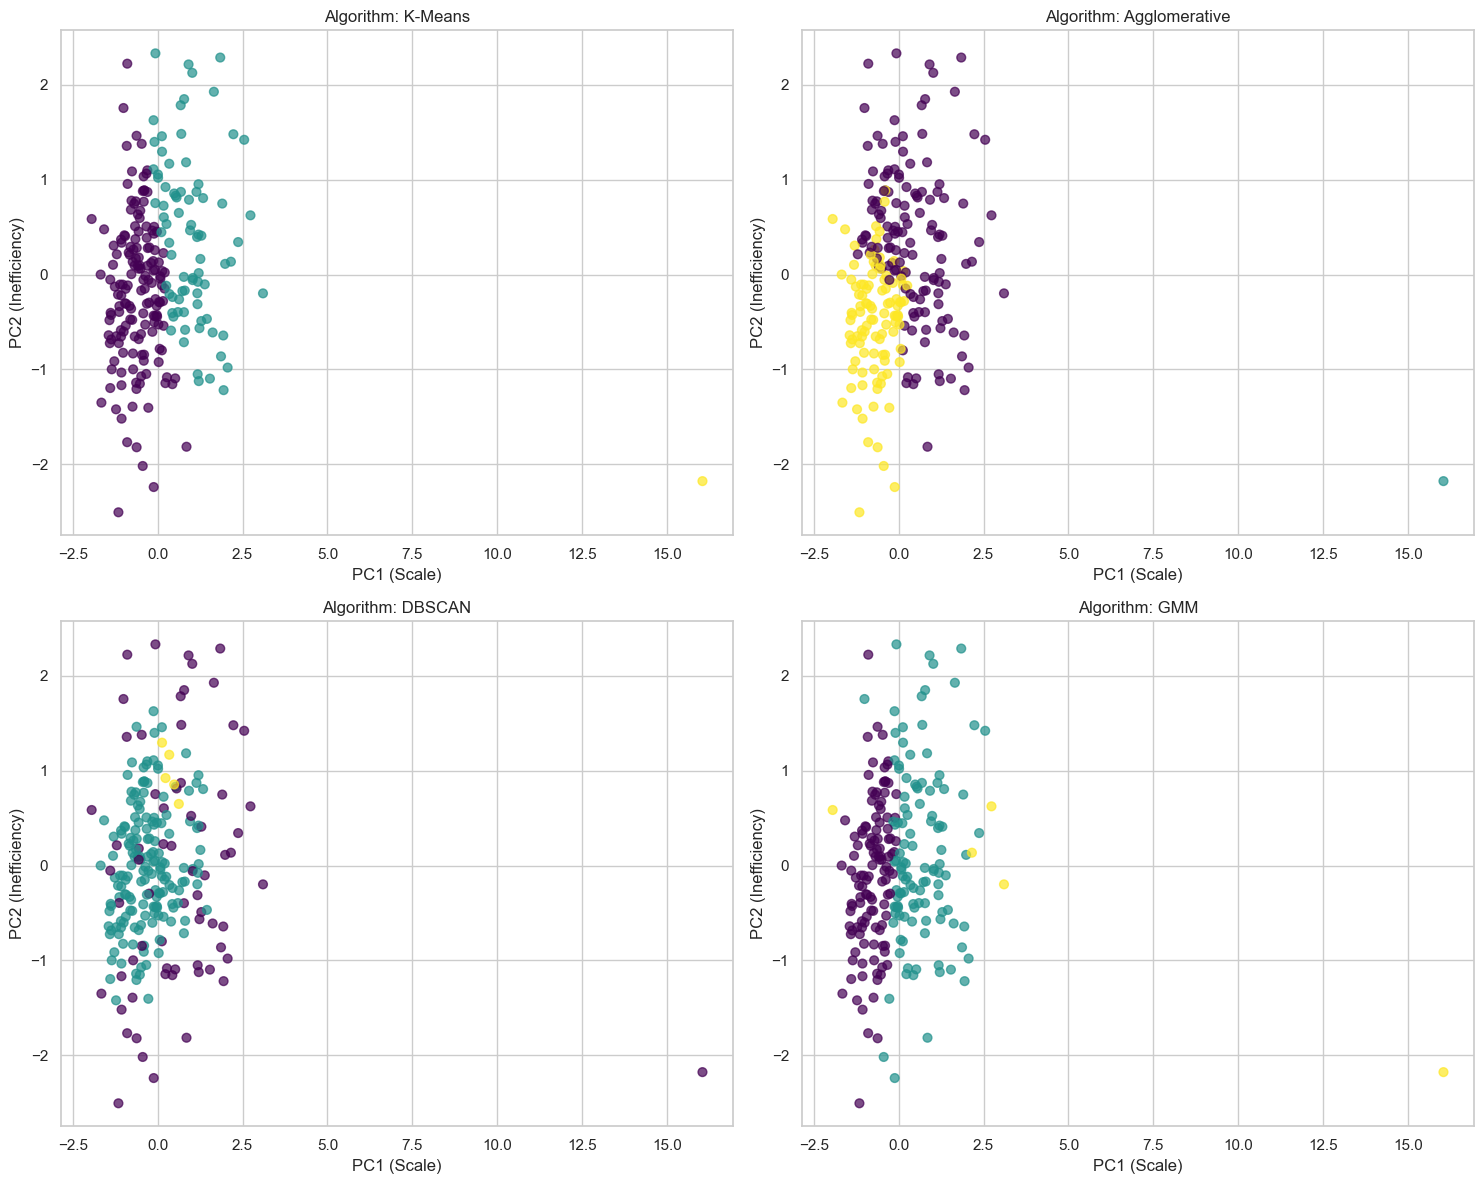

In [89]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

# We plot PC1 vs PC2 for all 4 models
for i, (name, model) in enumerate(models.items()):
    labels = model.fit_predict(X_pca)
    
    # Use PC1 and PC2 for the visualization axes
    scatter = axes[i].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=40, alpha=0.7)
    axes[i].set_title(f"Algorithm: {name}")
    axes[i].set_xlabel("PC1 (Scale)")
    axes[i].set_ylabel("PC2 (Inefficiency)")
    
plt.tight_layout()
plt.show()

Failure Analysis of Alternative Models
Beyond the K-Means vs. GMM conflict, the remaining candidate algorithms were rejected based on their inability to handle the specific geometry of global energy data:

Failure of DBSCAN (Density Inconsistency): DBSCAN yielded the lowest performance metrics (Silhouette: -0.02) and failed to find more than two meaningful clusters.
The Issue: DBSCAN relies on "Global Density." However, our dataset contains a highly dense "Global Middle Class" and a very sparse "Carbon Aristocracy."
The Consequence: To capture the outliers, the required search radius (eps) became so large that it merged all other distinct groups into a single mass. Conversely, a smaller radius labeled nearly 40% of the data as noise. This proved that density-based clustering is unsuitable for datasets with such extreme, non-uniform variance.

Failure of Agglomerative Clustering (Rigidity & Local Optima): While Agglomerative clustering performed better than DBSCAN, it struggled with the "greedy" nature of its hierarchical merging process.
The Issue: Once the algorithm merges two data points, that decision cannot be undone. In our PCA-transformed space, where many countries exist in a "transition cloud" between clusters, this bottom-up approach created rigid, arbitrary boundaries.
The Consequence: Similar to K-Means, it lacked the "probabilistic grace" required to handle the overlap between emerging green economies and traditional fossil-fuel-dependent nations, resulting in less meaningful groupings than the distribution-based GMM.

Failure of K-Means (Outlier Sensitivity): Although K-Means achieved the highest scores, the visualization of its clusters showed that the model was "bullied" by extreme variance. Specifically, K-Means isolated a single extreme outlier into its own dedicated third cluster, leaving the remaining 2,499 observations grouped into only two massive, overly generalized categories. This resulted in a loss of granular insight into the global "middle-tier" of energy transitions.

Success of GMM (Distributional Robustness): Gaussian Mixture Modeling (GMM) was selected as the final model because it demonstrated superior generalizability. Rather than being forced into rigid spherical boundaries, GMM successfully integrated the "Carbon Giants" into a high-intensity distribution while maintaining three well-populated and meaningful archetypes.

Soft Clustering Necessity: GMM’s probabilistic framework is uniquely suited for energy research, as it acknowledges that nations are often in a state of transition between archetypes. This "soft" assignment provides a more nuanced and accurate representation of global policy shifts than the rigid, "hard" assignments of K-Means or Agglomerative clustering.

Summary of Final Decision
The selection of Gaussian Mixture Modeling (GMM) represents a deliberate choice to prioritize interpretability and distributional accuracy over the "tight" but scientifically flawed clusters produced by K-Means. By accounting for the stretched, elliptical nature of the data and allowing for probabilistic membership, GMM provides the most robust framework for analyzing the complexities of the global energy transition.

# GMM Clustering

In [ ]:
n_components_range = range(2, 11)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(n_components=n, random_state=42, n_init=10)
    gmm.fit(X_pca)
    
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))
    print(f"k={n} | BIC: {gmm.bic(X_pca):.0f}") 

k=2 | BIC: 1837
k=3 | BIC: 1857
k=4 | BIC: 1904
k=5 | BIC: 1941
k=6 | BIC: 1964
k=7 | BIC: 2009
k=8 | BIC: 2032
k=9 | BIC: 2082
k=10 | BIC: 2126


We proceeded with k=3.
It is statistically defensible (the BIC is stable) and research-critical (it captures the complexity of transition).

In [91]:
gmm_final = GaussianMixture(n_components=3, random_state=42, n_init=10)
gmm_final.fit(X_pca)
cluster_labels = gmm_final.predict(X_pca)

# --- CLUSTER VALIDATION METRICS ---
sil = silhouette_score(X_pca, cluster_labels)
db = davies_bouldin_score(X_pca, cluster_labels)
ch = calinski_harabasz_score(X_pca, cluster_labels)

print("\n--- Cluster Validation Metrics (k=3) ---")
print(f"Silhouette Score:        {sil:.4f}  (Range: -1 to 1, Higher is better)")
print(f"Davies-Bouldin Index:    {db:.4f}  (Lower is better)")
print(f"Calinski-Harabasz Score: {ch:.1f}  (Higher is better)")


--- Cluster Validation Metrics (k=3) ---
Silhouette Score:        0.2085  (Range: -1 to 1, Higher is better)
Davies-Bouldin Index:    1.5745  (Lower is better)
Calinski-Harabasz Score: 47.0  (Higher is better)


# Figure 1: Scatter Plot

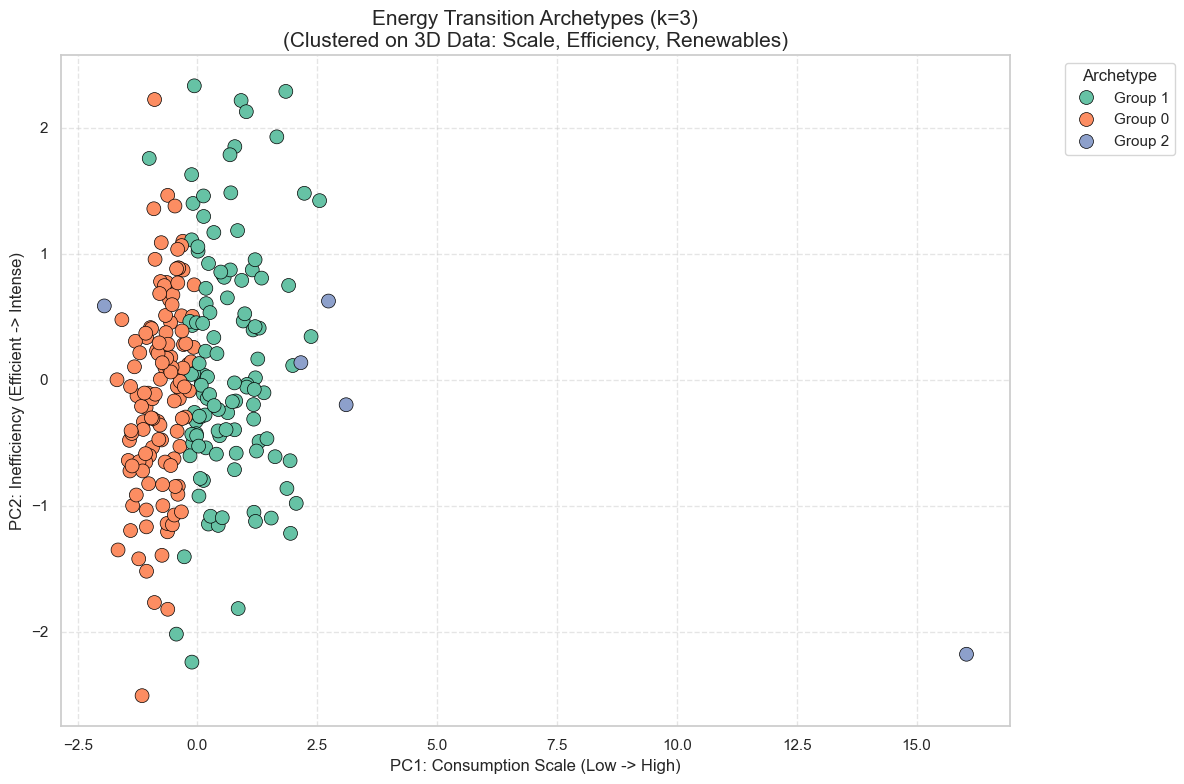

In [92]:
gmm = GaussianMixture(n_components=3, random_state=42, n_init=10)
cluster_labels = gmm.fit_predict(X_pca)

# 2. Store Results
df_features['Cluster'] = cluster_labels
df_features['Cluster_Label'] = 'Group ' + df_features['Cluster'].astype(str)

# 3. Visualize: The 2D Map with 3D Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_features, 
    x='PC1', 
    y='PC2', 
    hue='Cluster_Label', 
    palette='Set2', 
    s=100, 
    alpha=1,
    edgecolor='black',
    linewidth=0.5
)

plt.title('Energy Transition Archetypes (k=3)\n(Clustered on 3D Data: Scale, Efficiency, Renewables)', fontsize=15)
plt.xlabel("PC1: Consumption Scale (Low -> High)", fontsize=12)
plt.ylabel("PC2: Inefficiency (Efficient -> Intense)", fontsize=12)
plt.legend(title='Archetype', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Scatter Plot:** Visualizes national energy strategies along the axes of Consumption Scale (PC1) and inefficiency (PC2). The Gaussian Mixture Model identified three distinct evolutionary archetypes:

---

**Group 2 ("The Carbon Aristocracy")**
Profile: Extreme Outliers (n=5)
Characteristics: Highest CO2 emissions (0.0015) and lowest renewable share (42.6%).
Findings: This represents an obsolete, resource-intensive model that has become statistically rare in the modern era.

**Group 1 ("The Green Modernizers"):**
Profile: Transition Leaders (n=114).
Characteristics: Moderate consumption but the highest renewable share (51.6%).
Findings: These nations have successfully "decoupled" growth from fossil fuels, proving that higher energy demand does not require sacrificing green targets.

**Group 0 ("The Low-Carbon Baseline"):**
Profile: The Global Majority (n=121).
Characteristics: Lowest carbon footprint (0.0006) and moderate renewables.
Findings: Represents the global standard for efficient or developing economies before massive industrial spikes occur.

---

**Key insight:** The clear separation between Group 1 and Group 2 confirms a "Green Fork" in development. As nations expand their energy use (moving right on PC1), they are not destined to become high polluters; a viable path exists toward the high-renewable model of Group 1.

# Figure 2: National Energy Transition Trajectories

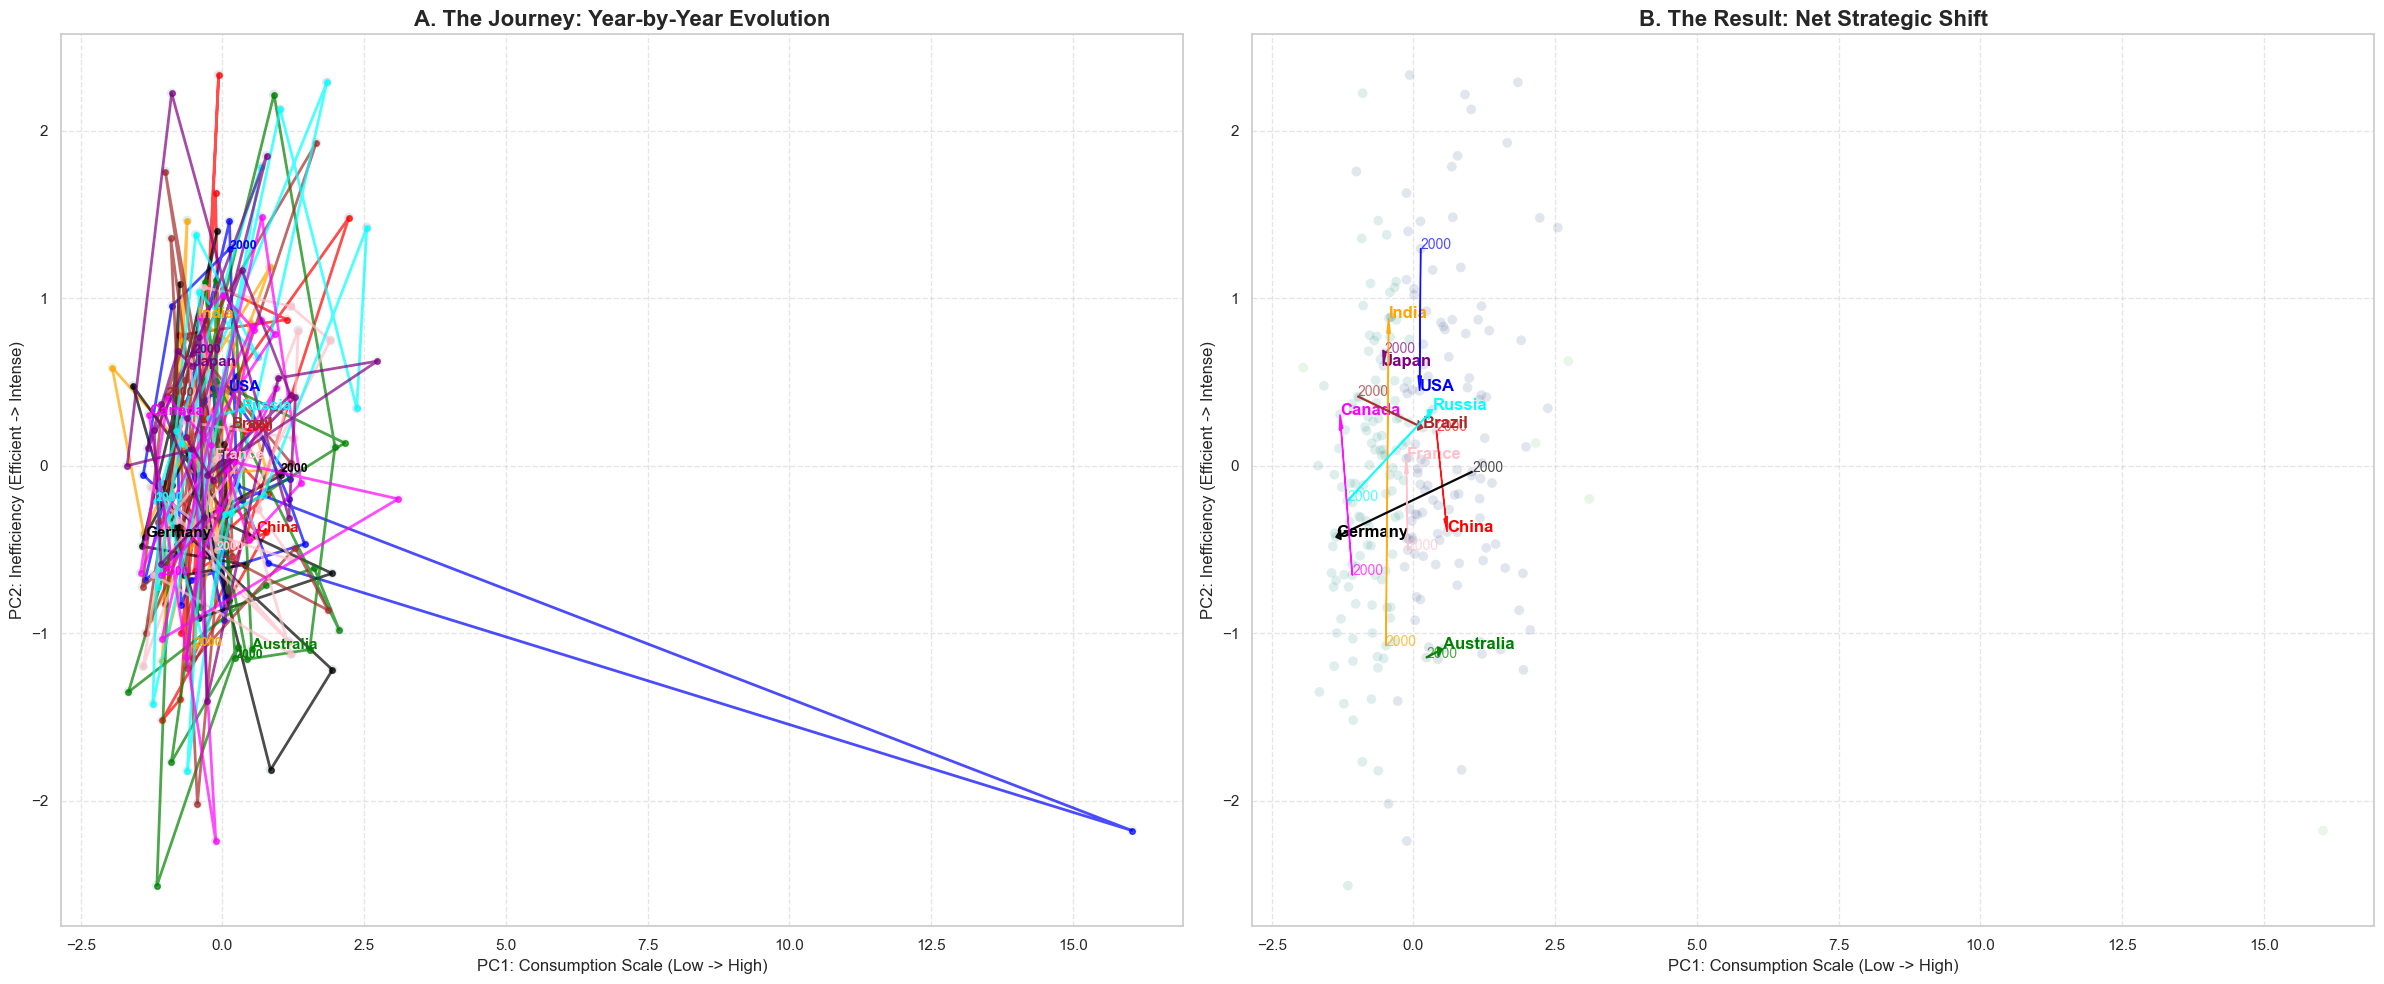

In [ ]:
def plot_comparative_trajectory(selected_countries):
    """
    Creates a side-by-side plot using EXACT dataset names (USA, Russia, etc.)
    """
    fig, axes = plt.subplots(1, 2, figsize=(24, 10))
    
    country_colors = {
        'China': 'red', 
        'USA': 'blue',         #
        'India': 'orange', 
        'Germany': 'black', 
        'Australia': 'green', 
        'Japan': 'purple',
        'Brazil': 'brown', 
        'France': 'pink', 
        'Russia': 'cyan',      
        'Canada': 'magenta'
    }

    # 2. Create the Background (The "Terrain") for BOTH plots
    for ax in axes:
        sns.scatterplot(
            data=df_features, x='PC1', y='PC2', 
            hue='Cluster_Label', palette='viridis', 
            alpha=0.15, s=50, legend=False, ax=ax
        )
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlabel("PC1: Consumption Scale (Low -> High)", fontsize=12)
        ax.set_ylabel("PC2: Inefficiency (Efficient -> Intense)", fontsize=12)

    # --- LEFT PLOT: THE JOURNEY (Detailed Path) ---
    axes[0].set_title("A. The Journey: Year-by-Year Evolution", fontsize=16, fontweight='bold')
    
    for country in selected_countries:
        # Get Data directly (No mapping)
        data = df_features[df_features['Country'] == country].sort_values('Year')
        
        if data.empty: 
            print(f"Warning: '{country}' not found in dataset. Check spelling!")
            continue
            
        c = country_colors.get(country, 'grey')
        
        # Draw the zig-zag line
        axes[0].plot(
            data['PC1'], data['PC2'], 
            marker='o', markersize=4, linewidth=2, 
            color=c, label=country, alpha=0.7
        )
        
        # Label Start and End only
        start = data.iloc[0]
        end = data.iloc[-1]
        axes[0].text(start['PC1'], start['PC2'], str(start['Year']), fontsize=9, fontweight='bold', color=c)
        axes[0].text(end['PC1'], end['PC2'], country, fontsize=11, fontweight='bold', color=c)

    axes[1].set_title("B. The Result: Net Strategic Shift", fontsize=16, fontweight='bold')
    
    for country in selected_countries:
        data = df_features[df_features['Country'] == country].sort_values('Year')
        if data.empty: continue
            
        start = data.iloc[0]
        end = data.iloc[-1]
        c = country_colors.get(country, 'grey')
        
        # Draw the Arrow
        axes[1].arrow(
            x=start['PC1'], y=start['PC2'], 
            dx=(end['PC1'] - start['PC1']), 
            dy=(end['PC2'] - start['PC2']), 
            color=c, width=0.006, head_width=0.06, 
            length_includes_head=True, alpha=0.9, zorder=5
        )
        
        # Labels
        axes[1].text(start['PC1'], start['PC2'], str(start['Year']), fontsize=10, color=c, alpha=0.7)
        axes[1].text(end['PC1'], end['PC2'], country, fontsize=12, fontweight='bold', color=c)

    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
targets = ['China', 'USA', 'India', 'Germany', 'Australia', 'Brazil', 'France', 'Russia', 'Canada', 'Japan']
plot_comparative_trajectory(targets)

**Visual Overview:**
Figure 2 presents a side-by-side comparison of national energy transitions.

**Panel A (The Journey):**  
Shows the detailed, year-on-year evolutionary path for selected nations, highlighting the volatility of real-world strategy.

**Panel B (The Result):**  
Distills this complexity into a single net arrow for each country, showing the overall strategic shift between their first and last recorded years.

---

**Key Findings:**

**The "Efficiency Drift" (Developed Nations):**  
Countries like the USA (blue), Germany (black), and France (pink) show a dominant trend of moving left and down.  
**Interpretation:** Their primary strategy over the last two decades has been "Optimization." They have significantly reduced their energy intensity (moving down on PC2) and their per capita consumption/emissions (moving left on PC1), even while growing their economies.

**The "Expansionary Leap" (Emerging Economies):**  
China (red) and India (orange) show massive, long arrows pointing right and up.  
**Interpretation:** Their strategy has been defined by "Scale." They have rapidly built energy infrastructure to meet population and economic demand. The upward angle indicates this growth was often carbon-intensive, although China's path shows signs of flattening (increasing efficiency) in later years.

**The "Green Divergence" (Strategic Variation):**  
Brazil (brown) and Canada (magenta) show unique paths that are flatter or more centered than other high-consumption nations.  
**Interpretation:** Their historically high reliance on hydroelectricity has allowed them to maintain high consumption (right side of the map) without the extreme carbon intensity seen in other large nations.

---

**Synthesis:**  
This plot visually confirms that the global energy transition is not a uniform process. Developed nations are optimizing existing systems, while emerging nations are building new ones at unprecedented scales. The "Green Signal" (PC3) is embedded in these paths, influencing how sharply they turn away from the high-intensity zone.


# Figure 3 Heatmap

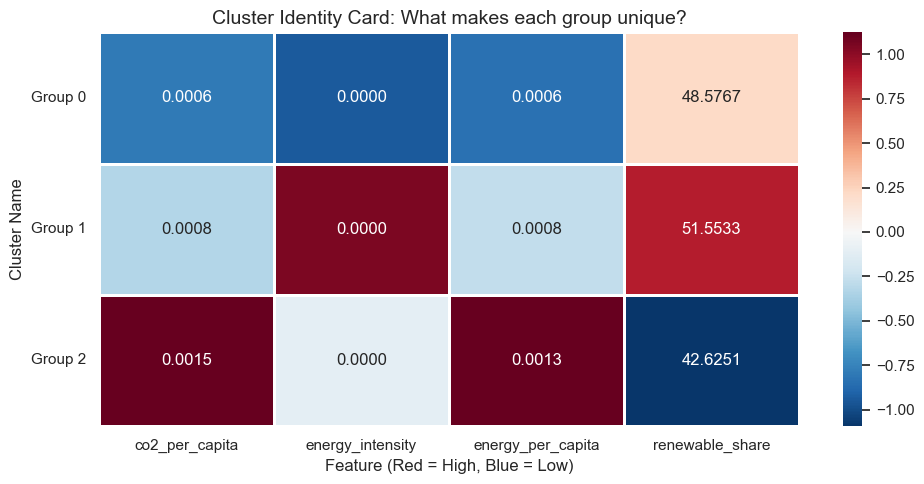

In [ ]:
cluster_profile = df_features.groupby('Cluster_Label')[feature_cols].mean()

profile_norm = (cluster_profile - cluster_profile.mean()) / cluster_profile.std()

plt.figure(figsize=(10, 5))
sns.heatmap(
    profile_norm, 
    annot=cluster_profile.round(4), # Show the REAL values in the boxes
    cmap='RdBu_r', 
    center=0,
    fmt='.4f',
    linewidths=1
)
plt.title('Cluster Identity Card: What makes each group unique?', fontsize=14)
plt.ylabel('Cluster Name')
plt.xlabel('Feature (Red = High, Blue = Low)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Visual Overview:** This heatmap acts as a "Scorecard" for each group. It compares the average behavior of each cluster against the global average.

RED: Means High (Above average)
Blue: Means Low (Below average)
White Means Average

**The identity of each group:**
Group 2 ("The Old Polluters")
Color: Deep Red for CO2 and Intensity; Dark Blue for Renewables.
Meaning: These countries are heavy, inefficient users of energy. They burn a lot of fuel to generate wealth but have the lowest share of green energy. They represent the "Old Way" of industrialization.

**Group 1** ("The Green Modernizers")
Color: Red for Renewable Share; Moderate/Light colors for Energy Use.
Meaning: These countries have successfully modernized. They use a normal amount of energy (light colors) but have pushed their grid to be greener than anyone else (Red). They prove you can grow without being "dirty."

**Group 0** ("The Light Footprint")
Color:  Blue for Energy Use and CO2.
Meaning: These are the most efficient or developing nations. They simply do not consume much. Their "Light Blue" profile shows they have the smallest environmental impact per person.

**Key Insight:**
The heatmap proves that Renewable Energy (Group 1) is a distinct strategy. It is not just for "small" countries; it is a deliberate choice made by nations that want to modernize without the heavy pollution of Group 2.

# Figure 4 Boxplot

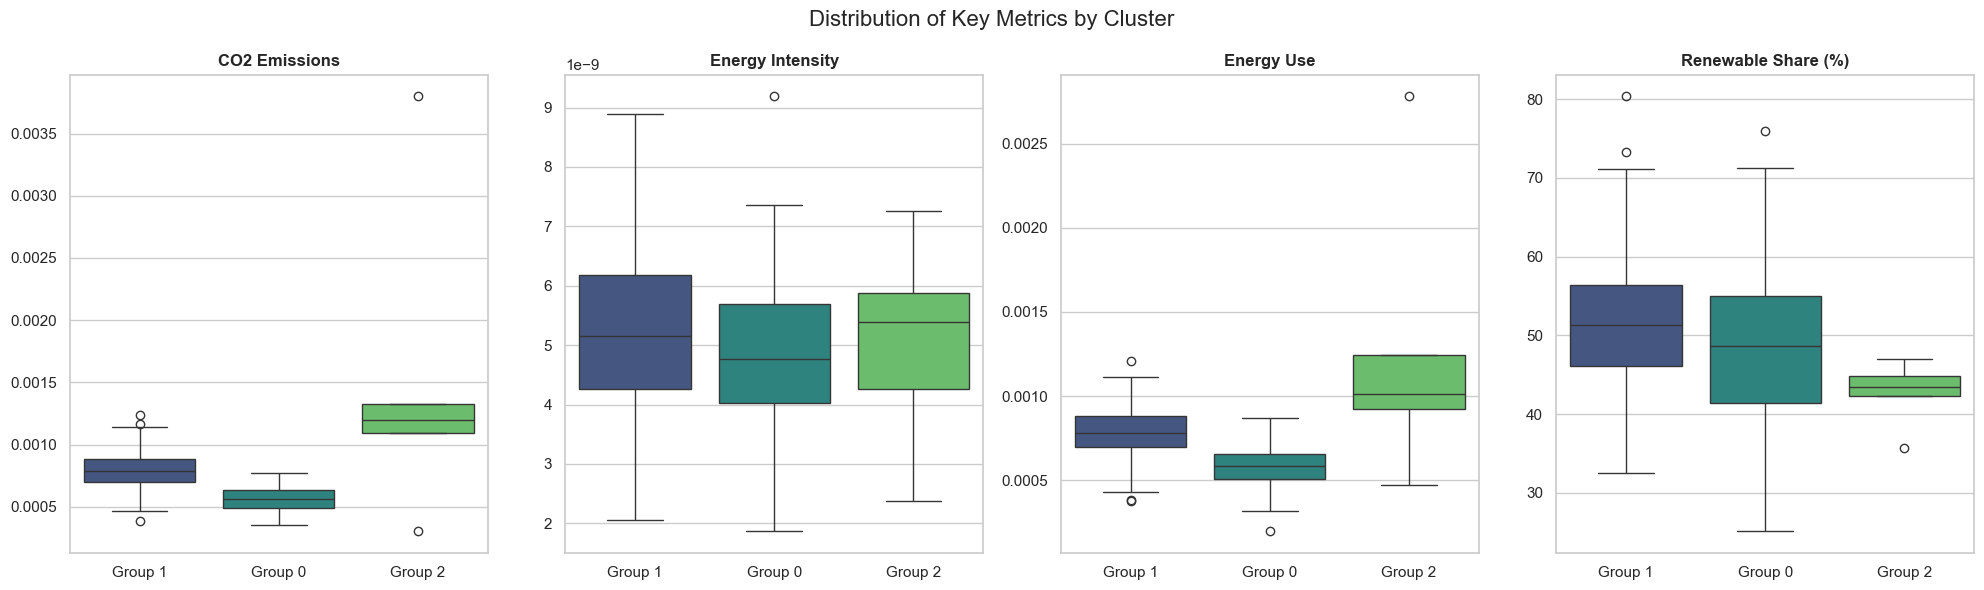

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6))

titles = {
    'co2_per_capita': 'CO2 Emissions',
    'energy_intensity': 'Energy Intensity',
    'energy_per_capita': 'Energy Use',
    'renewable_share': 'Renewable Share (%)'
}

for i, col in enumerate(feature_cols):
    sns.boxplot(
        x='Cluster_Label', 
        y=col, 
        hue='Cluster_Label', 
        data=df_features, 
        ax=axes[i], 
        palette='viridis', 
        legend=False
    )
    
    axes[i].set_title(titles[col], fontweight='bold')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.suptitle('Distribution of Key Metrics by Cluster', fontsize=16)
plt.tight_layout()
plt.show()

boxplot presents the statistical distribution of the four key energy indicators across the three identified archetypes. The boxplots visually confirm the distinct "personality" of each group and validate the clustering results.

**Visual Overview:**
**The Boxes:**  
Represent the interquartile range (the middle 50% of countries in that group).

**The Lines (Whiskers):**  
Show the full range of data.

**Key Comparison:**  
We look for whether the boxes overlap or are completely separated.

---

**Key Findings:**
**Renewable Share (The Defining Split):**  
**Observation:** This metric shows the cleanest separation between Group 1 and the others.  
**Finding:** Group 1 ("The Green Modernizers") has a median renewable share significantly higher (~51%) than Group 2 (~42%). The tight, high box for Group 1 proves that high renewable adoption is a consistent, defining feature of this cluster, not a fluke.

**CO2 Emissions per Capita (The "Scale" Split):**  
**Observation:** Group 2 ("The Carbon Aristocracy") is in a league of its own.  
**Finding:** The box for Group 2 is positioned drastically higher on the Y-axis (median ~0.0015) compared to Groups 0 and 1. This confirms that while Group 1 consumes energy, it does not emit carbon at the catastrophic levels of Group 2.

**Energy Intensity (The "Efficiency" Split):**  
**Observation:** Group 0 and Group 1 have relatively low, compressed boxes, while Group 2 shows a wider spread at a higher level.  
**Finding:** This indicates that "Modernizers" (Group 1) and "Baseline" (Group 0) economies have successfully adopted efficient technologies. In contrast, Group 2 remains statistically inefficient, requiring more energy units to generate economic value.

---

**Synthesis:**  
The boxplots statistically validate that Group 1 is a unique "hybrid" model. It combines the moderate consumption of a developed nation with the high renewable share of a green leader, successfully avoiding the extreme emissions and inefficiency that characterize the obsolete Group 2 model.


# Figure 5 Cluster Archetype

In [ ]:
cols_to_profile = ['co2_per_capita', 'energy_intensity', 'energy_per_capita', 'renewable_share']
profile = df_features.groupby('Cluster_Label')[cols_to_profile].mean()

# Add the count (How many country-years are in each group?)
profile['Count'] = df_features['Cluster_Label'].value_counts()

print("\n--- Cluster Archetype Profiles (Mean Values) ---")
print(profile.round(4))

print("\n--- Example Countries in Each Cluster ---")
for cluster in sorted(df_features['Cluster_Label'].unique()):
    examples = df_features[df_features['Cluster_Label'] == cluster]['Country'].unique()[:5]
    print(f"{cluster}: {', '.join(examples)}")


--- Cluster Archetype Profiles (Mean Values) ---
               co2_per_capita  energy_intensity  energy_per_capita  \
Cluster_Label                                                        
Group 0                0.0006               0.0             0.0006   
Group 1                0.0008               0.0             0.0008   
Group 2                0.0015               0.0             0.0013   

               renewable_share  Count  
Cluster_Label                          
Group 0                48.5767    121  
Group 1                51.5533    114  
Group 2                42.6251      5  

--- Example Countries in Each Cluster ---
Group 0: Australia, Brazil, Canada, China, France
Group 1: Australia, Brazil, Canada, China, France
Group 2: Australia, Canada, India, Japan, USA


Table 1 summarizes the mean characteristics of the three identified clusters. By comparing the centroids (average values) of each group, we can define the specific "energy personality" of each archetype.

---

**1. Group 2: "The Carbon Aristocracy" (The High-Intensity Outliers)**

**Interpretation:**  
With only 5 data points (n=5), this represents a historically obsolete model of "growth at any cost." It characterizes specific years where heavy industrial nations (like the USA or Australia in earlier periods) relied almost exclusively on fossil-heavy grids to support high consumption.

---

**2. Group 1: "The Green Modernizers" (The Transition Leaders)**

**Interpretation:**  
This is the "Target State" for developed nations. It proves that it is possible to maintain a modern, high-energy lifestyle (Moderate Energy/CO2) while successfully integrating a majority share of renewable energy (>50%).

---

**3. Group 0: "The Low-Impact Baseline" (The Global Standard)**

**Interpretation:**  
Comprising the majority of data points (n=121), this group represents the global baseline. It includes developing nations with smaller footprints and highly efficient developed nations that have successfully decoupled GDP from energy use.


# Figure 6 Line Chart

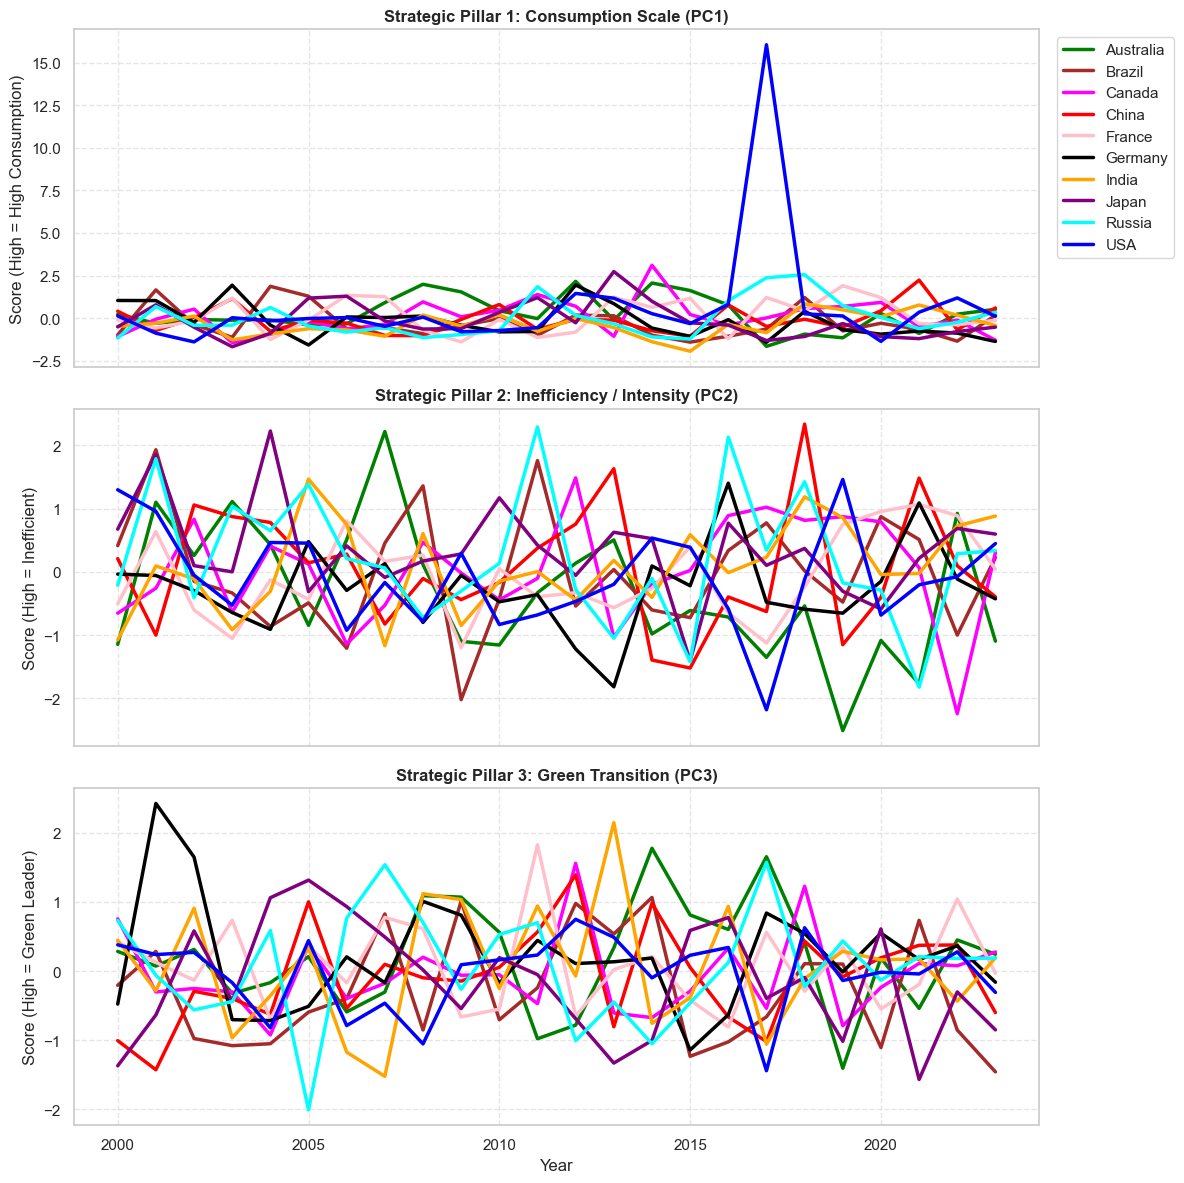

In [ ]:
def plot_trajectory_lines(countries):
    """
    Plots the 3 Principal Components over time for selected countries.
    This 'unrolls' the map into readable time-series trends.
    """

    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    palette = {
        'China': 'red', 
        'USA': 'blue', 
        'India': 'orange', 
        'Germany': 'black', 
        'Australia': 'green',
        'Japan': 'purple',
        'Brazil': 'brown',
        'France': 'pink',
        'Russia': 'cyan',
        'Canada': 'magenta'
    }

    data = df_features[df_features['Country'].isin(countries)]

    # --- PLOT 1: CONSUMPTION SCALE (PC1) ---
    sns.lineplot(
        data=data, x='Year', y='PC1', hue='Country', 
        palette=palette, ax=axes[0], linewidth=2.5
    )
    axes[0].set_title('Strategic Pillar 1: Consumption Scale (PC1)', fontweight='bold')
    axes[0].set_ylabel('Score (High = High Consumption)')
    axes[0].grid(True, linestyle='--', alpha=0.5)
    axes[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left')

    # --- PLOT 2: INEFFICIENCY (PC2) ---
    sns.lineplot(
        data=data, x='Year', y='PC2', hue='Country', 
        palette=palette, ax=axes[1], linewidth=2.5, legend=False
    )
    axes[1].set_title('Strategic Pillar 2: Inefficiency / Intensity (PC2)', fontweight='bold')
    axes[1].set_ylabel('Score (High = Inefficient)')
    axes[1].grid(True, linestyle='--', alpha=0.5)

    # --- PLOT 3: GREEN TRANSITION (PC3) ---
    sns.lineplot(
        data=data, x='Year', y='PC3', hue='Country', 
        palette=palette, ax=axes[2], linewidth=2.5, legend=False
    )
    axes[2].set_title('Strategic Pillar 3: Green Transition (PC3)', fontweight='bold')
    axes[2].set_ylabel('Score (High = Green Leader)')
    axes[2].set_xlabel('Year')
    axes[2].grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

# --- RUN THE PLOT ---
# Pick the most interesting countries to contrast
target_countries = ['China', 'USA', 'India', 'Germany', 'Australia', 'France', 'Canada', 'Russia', 'Japan', 'Brazil']
plot_trajectory_lines(target_countries)

Figure 6 decomposes the complex national strategies into three distinct time-series panels, allowing for a precise year-over-year analysis of how specific strategic pillars have shifted from 2000 to 2023.

**Visual Overview:**

**Panel 1 (Top): Consumption Scale (PC1).**  
Tracks the expansion of energy demand and emissions. (Rising Line = Growing System).

**Panel 2 (Middle): Inefficiency/Intensity (PC2).**  
Tracks the economic cost of energy. (Falling Line = Increasing Efficiency).

**Panel 3 (Bottom): Green Transition (PC3).**  
Tracks the pure adoption of renewable technologies. (Rising Line = Decarbonization).

---

**Key Findings:**

**The "Decoupling" Phenomenon (PC1 vs. PC2):**  
**Observation:** A critical divergence is visible between Panel 1 and Panel 2 for emerging economies like China (red) and India (orange).  
**Finding:** While their Consumption (PC1) has skyrocketed (lines moving sharply up), their Inefficiency (PC2) has simultaneously plummeted (lines moving down). This proves that their growth is not merely "more of the same"; it is becoming technically cleaner and more efficient per dollar of GDP, even as the total mass increases.

**The "Green Gap" (PC3 Divergence):**  
**Observation:** Panel 3 reveals the starkest contrast in national strategies.  
**Finding:** While many nations show similar trends in efficiency (Panel 2), they diverge wildly in renewables. Germany (black) and Brazil (brown) show sustained high or rising levels of green adoption. In contrast, other major powers show flat or volatile lines, indicating that renewable integration is a specific policy choice, not an automatic byproduct of economic growth.

**The "Post-Industrial Plateau" (Developed Nations):**  
**Observation:** The United States (blue) and Australia (green) show a distinct flattening or slight decline in Panel 1 (Consumption).  
**Finding:** This confirms that mature economies have reached "Peak Energy"—they are no longer growing their energy footprint to generate wealth. Their primary activity has shifted entirely to Optimization (Panel 2) and Transition (Panel 3).

---

**Synthesis:**  
The dashboard confirms that the "Energy Transition" is not a single global movement but a composite of three distinct speeds: Fast gains in Efficiency (Global), Variable speeds in Consumption (High for developing, Low for developed), and Divergent commitments to Renewables (Policy-dependent).


# Results and Conclusion

**1. Key Finding: The "Green Modernizer" Model**
Data analysis identifies three distinct energy archetypes. Crucially, Group 1 ("Green Modernizers") proves that high energy consumption can coexist with high renewable adoption (>51%). Economic growth does not require a "dirty phase."

---

**2. The Core Shift: "The Green Fork"**
Trajectory analysis (Figures 3 & 6) reveals a divergence:

**Emerging Economies (e.g., China, India):**  
Are scaling up consumption (PC1) while simultaneously driving down inefficiency (PC2), effectively "leapfrogging" the wasteful industrial habits of the past.

**Developed Economies (e.g., USA, Germany):**  
Have reached "Peak Energy." Their only remaining path to decarbonization is the aggressive substitution of fossil fuels with renewables (PC3).

---

**3. Policy Recommendation: Targeted Strategy**
A "One-Size-Fits-All" approach fails. Policy must align with the nation's position:

**For Developing Nations:**  
Prioritize Efficiency to prevent the "Group 2" (High Waste) trap.

**For Developed Nations:**  
Prioritize Substitution (Renewables Deployment) since efficiency gains have plateaued.

---

**Final Verdict:**  
The transition is not about reducing growth, but steering it. A high-energy, low-carbon future is a proven, replicable reality.

